# Description
Uses Markov Chain Monte Carlo to fit $b1$ and $\beta$ of the linear model. The MCMC package Zeus is used (documentation (https://zeus-mcmc.readthedocs.io/en/latest/index.html and useful cookbook https://zeus-mcmc.readthedocs.io/en/latest/notebooks/datafit.html). $\chi^2$ is the log-likelihood function and found as described in `Fitting_b1_different_kmax.ipynb`. By Bayes' theorem, the posterior distribution is given (up to a normalization constant) by the product of the likelihood function and the prior distribution. Consequently, log-posterior is just the sum of the log-likelihood and the log-prior.

Each walker explores the parameter space and produced a set of parameter values sampled from the posterior distribution. The number of walkers must be even and should be between 2 and 4 times the number of parameters (ndim). The starting point in parameter space of each walker is specified by `start`. From there, `nsteps` along the Markov Chain are taken.

To get access the sampled parameters, use `sampler.get_chain()`. Without any arguments this gives an array of shape `(nsteps, nwalkers, ndim)`. Set `flat=True` to get flat array. Can also specify that the first N samples of each walker (burn-in phase) should be discarded via `discard=N`. This is done before the flattening. Can also thin out chains by some factor via the argument `thin`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import inv_cov_funcs as icf
from astropy.cosmology import Planck18 as Planck18_astropy 
import zeus 
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0.2
BoxSize = 2000
cosmo = cosmology.Cosmology.from_astropy(Planck18_astropy)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
kmax = 0.05 # due to BoxSize, last bin with nonz zero Fourier mode is k = 0.343. Hence, kmax<0.343.
ells = [0,2]

In [4]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k_full, shotnoise, n_ptile, Pk_ells_full, mus, Pkmus_full = icf.load_power_data('/home/jwack/main/fitmodel_densitysplit/', 
                                                               ells, get_data_Pkmus=True)
# slice down arrays of k and multipoles
mask = k_full <= kmax
mask[0] = False 
k = k_full[mask]
Pk_ells = Pk_ells_full[:,:,mask]
Pkmus = Pkmus_full[:,mask,:] 

### Note on choice of prior
For uniform prior: When parameter in range, set prior to 1 (log prior to 0) and when outside range set to 0 (log prior to -inf)
Could have used more informed prior such as a normal one: 
```
    b1_mu, b1_sig = 1, 0.5
    lp_b1 = -0.5*((b1-b1_mu)/b1_sig)**2 #if beta > 0 else: -np.inf 
    beta_mu, beta_sig = 1.1, 1
    lp_beta = -0.5*((beta-beta_mu)/beta_sig)**2 if beta > 0 else -np.inf 
```
Not recommended to use with static mean and variance as b1, beta change significantly across the density bins.

In [5]:
def logprior(theta, i):
    ''' The natural logarithm of the prior probability. Assume parameters independent such that log priors add.
    Note that normalization is irrelevant for MCMC.'''
    lp = 0.
    b1, beta = theta
    # choose uniform priors for both parameters.
    b1_min, b1_max = 0, 3
    if i == 0:
        beta_min, beta_max = -3, 3
    else:
        beta_min, beta_max = 0, 3
    
    lp_b1 = 0. if b1_min < b1 < b1_max else -np.inf
    lp_beta = 0. if beta_min < beta < beta_max else -np.inf

    return lp_b1 + lp_beta


def loglike(theta, data_multipoles, k, C_inv):
    '''Return logarithm of likelihood i.e. -0.5*chi2.
    data_multipoles must be an array of shape (len(ells), len(k)). theta is parameter vector: [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2] and purely linear Kaiser theory. Alternative described in 
    minimizing chi2 and ABC fitting notebooks.'''
    b1, beta = theta
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    
    return -0.5*D_M@(C_inv @ D_M)


def logpost(theta, i, data_multipoles, k, C_inv):
    '''Returns the logarithm of the posterior. By Bayes' theorem, this is just the sum of the log prior and log likelihood (up 
    to a irrelavant constant).
    ''' 
    return logprior(theta, i) + loglike(theta, data_multipoles, k, C_inv)

In [6]:
# arrays full of NaN. When not enough candidates accepted, NaN remains and percentile will not be plotted
b1_fits, beta_fits = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # mean of accepted parameters
b1_stds, beta_stds = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # standard deviation of accepted parameters
delta_fs8, delta_fs8_stds = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # relative difference to true f_0*sigma_8 
reduced_chi2 = np.full(n_ptile, np.nan) # reduced chi at mean of accepted parameters 

ndim = 2
nwalkers = 6 
nsteps = 1000
chains = [] # keep track of all unprocessed chains to have option to plot individually later 

start = 0.5 + np.random.random((nwalkers, ndim)) # initial positions: randomly choosen between 0.5 and 1.5 

for i in range(n_ptile):
    t1 = time.time()
    ### choose between analytic or mock covariance matrix ###
    C_inv = icf.gaussian_cov_mat_inv(k, ells, BoxSize, shotnoise, dk, Pkmus[i], mus) # analytic with data P(k,mu)
#     cov_mat = np.loadtxt('/home/jwack/main/fitmodel_densitysplit/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
#     C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax) # mock 
    
    # Initialise the sampler. To see progress of sampling set verbose=True
    sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[i, Pk_ells[i], k, C_inv]) 
    sampler.run_mcmc(start, nsteps) # Run sampling
    sampler.summary # Print summary diagnostics
    
    chains.append(sampler.get_chain())
    chain = sampler.get_chain(flat=True, discard=nsteps//2)
    
    b1_fits[i], b1_stds[i] = np.mean(chain[:,0]), np.std(chain[:,0]) 
    # See Markdown cell '0-th bin' for explanation 
    if i == 0:
        b1_fits[i] *= -1
    beta_fits[i], beta_stds[i] = np.mean(chain[:,1]), np.std(chain[:,1])
    delta_fs8[i] = 1 - sigma8_lin*(beta_fits[i]*b1_fits[i])/(f0_true*sigma8_true)
    delta_fs8_stds[i] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(beta_stds[i]*b1_fits[i]+beta_fits[i]*b1_stds[i]))        
    reduced_chi2[i] = -2*loglike([b1_fits[i], beta_fits[i]], Pk_ells[i], k, C_inv) / (2*len(k)-2)
    
    t2 = time.time()
    print('Fitted %d-th percentile in %.2f sec'%(i,t2-t1))

Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.15it/s]


Fitted 0-th percentile in 15.37 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.81it/s]


Fitted 1-th percentile in 12.09 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.45it/s]


Fitted 2-th percentile in 6.44 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.59it/s]


Fitted 3-th percentile in 11.69 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.86it/s]


Fitted 4-th percentile in 16.18 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.81it/s]


Fitted 5-th percentile in 6.64 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.04it/s]


Fitted 6-th percentile in 9.35 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.42it/s]


Fitted 7-th percentile in 6.36 sec


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.86it/s]


Fitted 8-th percentile in 10.34 sec


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.60it/s]

Fitted 9-th percentile in 7.03 sec


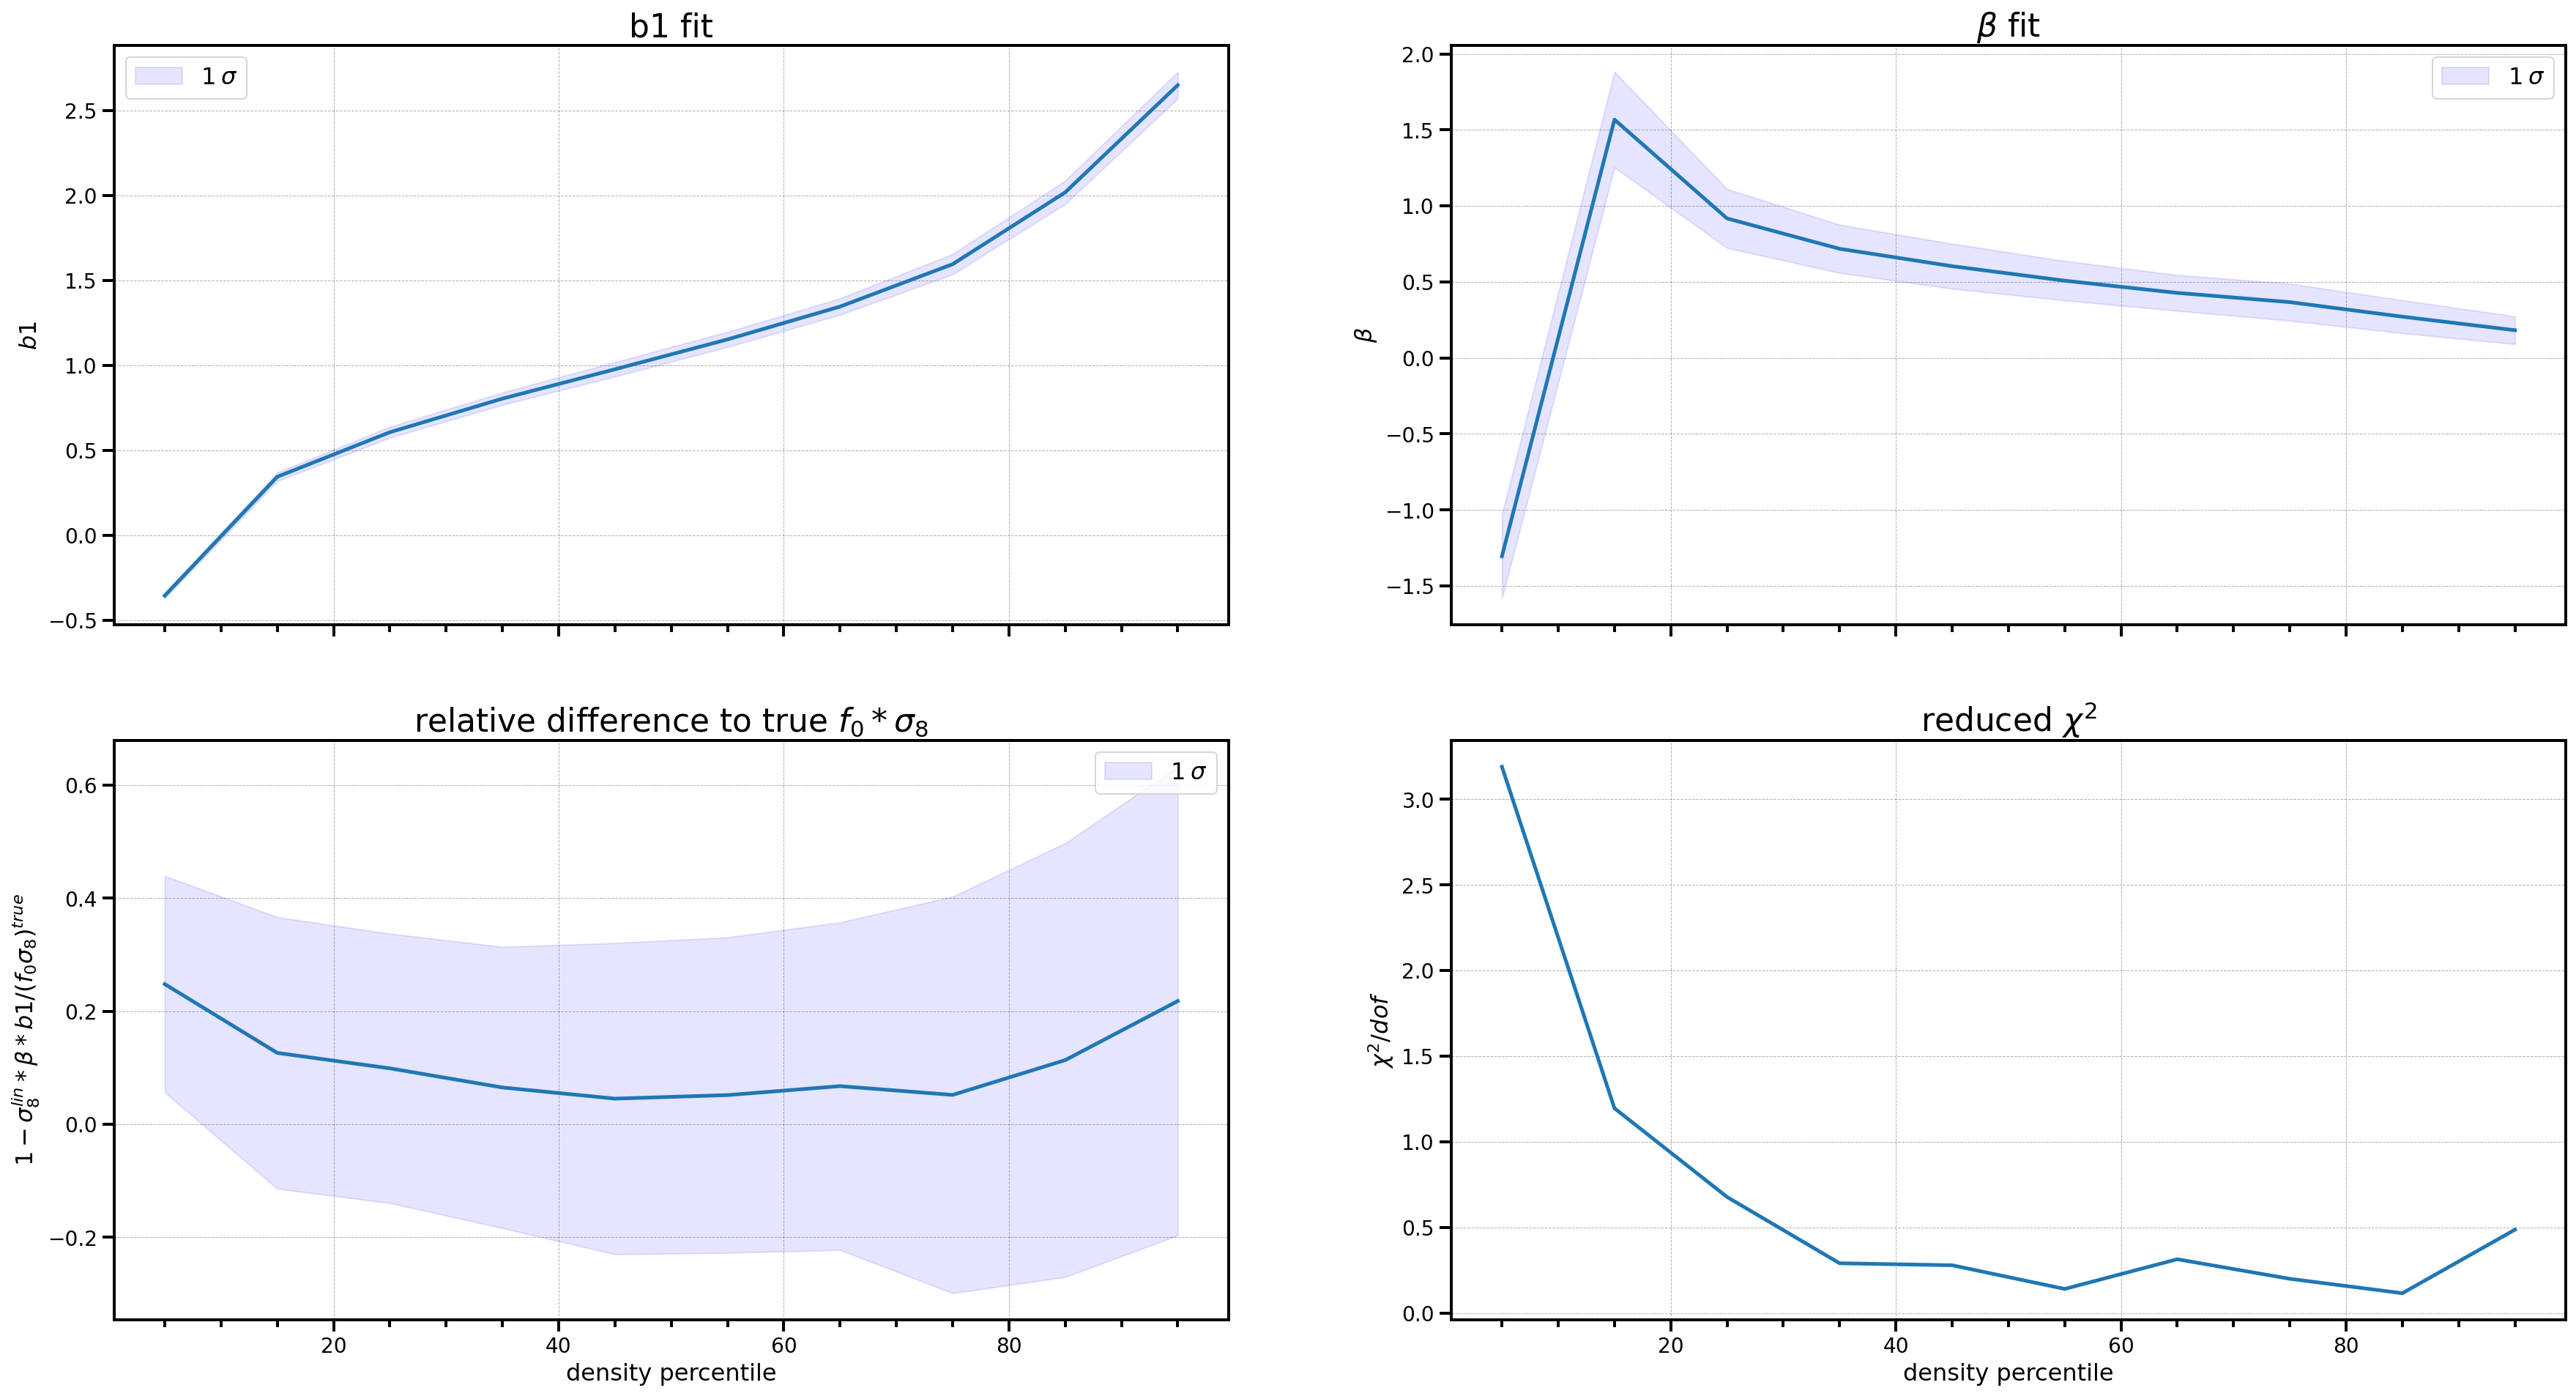

In [7]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10) # percentile mid points

axs[0][0].plot(mids, b1_fits)
axs[0][0].fill_between(mids, (b1_fits-b1_stds), (b1_fits+b1_stds), color='b', alpha=0.1, label=r'$1 \: \sigma$')
axs[0][0].set_title("b1 fit")
axs[0][0].set_ylabel(r"$b1$")
axs[0][0].legend()

axs[0][1].plot(mids, beta_fits)
axs[0][1].fill_between(mids, (beta_fits-beta_stds), (beta_fits+beta_stds), color='b', alpha=0.1, label=r'$1 \: \sigma$')
axs[0][1].set_title(r"$\beta$ fit")
axs[0][1].set_ylabel(r"$\beta$")
axs[0][1].legend()

axs[1][0].plot(mids, delta_fs8)
axs[1][0].fill_between(mids, (delta_fs8-delta_fs8_stds), (delta_fs8+delta_fs8_stds), color='b', alpha=0.1, label=r'$1 \: \sigma$')
axs[1][0].set_title(r"relative difference to true $f_0*\sigma_8$")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$1 - \sigma_8^{lin}*\beta*b1 / (f_0\sigma_8)^{true}$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].legend()

axs[1][1].plot(mids, reduced_chi2)
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_MCMC_analytic.pdf')

### Interpretation
The fitted values are very similar to the ones found by minimizing chi2. Notably, `fs8` is underestimated across all bins which might be due to not including a FoG term in the model which dampens the power spectrum.

### 0-th bin
From previous analysis we know that the data quadrupole is fully negative which causes a negative $\beta$ to be fitted. When constraining $\beta$ through the prior to be non-negative, we expect to get $\beta=0$ fitted which leads to `delta_fs8[0]` $\approx 1$.

Note that in Kaiser model, only $b1^2$ occurs. Hence we are not sensitive to the sign of $b1$. This is illustrated by the symmetry of the $\chi^2$ grid about $b1=0$. As mentioned above, for the 0-th bin we need to allow for negative $\beta$ but as $f_0 = b1*\beta \sim \Omega_m^{0.6}$ must be non negative, we always need $b1, \beta$ to have the same sign. As $b1<0$ and $b1>0$ are equivalent, we can restrict $b1$ through its prior to be positive and just take its negated value to infer $f_0$ when $\beta<0$.

In [ ]:
from matplotlib import colors

ptile_idx = 0
kmax = k_full[11]
cov_mat = np.loadtxt('/home/jwack/main/fitmodel_densitysplit/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%ptile_idx)
C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax)

# b1s = np.linspace(-1,0,100)
# betas = np.linspace(-3,0,100)
b1s = np.linspace(-2,2,100)
betas = np.linspace(-3,3,100)

log_likelihood = np.full((len(b1s),len(betas)), np.nan)

mask = np.full(len(k_full), False)
mask = k_full <= kmax
mask[0] = False 
k_sliced = k_full[mask]
Pk_ells_idx = Pk_ells_full[:,:,mask][ptile_idx]

for i,b1 in enumerate(b1s):
    for j,beta in enumerate(betas):
        log_likelihood[i][j] = loglike([b1,beta], Pk_ells_idx, k_sliced, C_inv)

In [ ]:
# due to how log_likelihood was filled up, we have b1 constant across rows, beta constant across columns
fig = plt.figure(figsize=(8,8))
# extent = [left, right, bottom, top] in data coords
matplot = plt.imshow(-2*log_likelihood, extent=[betas[0], betas[-1], b1s[-1], b1s[0]], norm=colors.LogNorm(), aspect='auto')
plt.colorbar(matplot, ax=plt.gca())
plt.title(r'$\chi^2$ for $0-th$ on $\beta-b1$ gird')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$b1$')

### Extra plots

- Make walker plots, showing value of $b1$ and $\beta$ over different steps along the chain for each walker
- Corner plot of posterior distributions. Values in header are dependent on what is passed as quantiles. By default `quantiles=[0.025, 0.5, 0.975]`, meaning that 2.5%, 50%, 97.5% of all values are to the left of the values in the header. 
    See https://zeus-mcmc.readthedocs.io/en/latest/api/plotting.html?highlight=cornerplot#zeus.cornerplot and https://github.com/minaskar/zeus/blob/76ae77de9f3218008dca9882ef7e16bd42405d1b/zeus/plotting.py#L177-L183.
    Also shows the smoothed 2D parameter distribution with contours corresponding to 0.5, 1, 1.5, and 2 sigma.

In [ ]:
cur_chain = chains[4]

In [ ]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(cur_chain[:,:,n], alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Needs 'flattened' chain: (number walkers * number steps, ndim) i.e treats all walkers equally 
fig, axes = zeus.cornerplot(cur_chain.reshape((-1,ndim), order='F'), labels=[r'$b1$', r'$\beta$']);